# Assignment 9: GBDT

#### Response Coding: Example

<img src='http://i.imgur.com/TufZptV.jpg' width=700px>

> The response tabel is built only on train dataset.
> For a category which is not there in train data and present in test data, we will encode them with default values
e.g: in our test data if have State: D then we encode it as [0.5, 0.05]

In [6]:
from google.colab import drive
drive._mount('/content/drive')

Mounted at /content/drive


In [7]:
import pickle
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from tqdm import tqdm
import numpy as np
from scipy.sparse import hstack
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore")

In [9]:
# please use below code to load glove vectors 
with open('/content/drive/MyDrive/Data Sets/Donors Choose/glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words = set(model.keys())

<ol>
    <li><strong>Apply GBDT on these feature sets</strong>
        <ul>
            <li><font color='red'>Set 1</font>: categorical(instead of one hot encoding, try <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/'>response coding</a>: use probability values), numerical features + project_title(TFIDF) + preprocessed_eassay (TFIDF) + sentiment Score of eassay(check the bellow example, include all 4 values as 4 features)</li>
            <li><font color='red'>Set 2</font>: categorical(instead of one hot encoding, try <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/'>response coding</a>: use probability values), numerical features + project_title(TFIDF W2V) + preprocessed_eassay (TFIDF W2V)</li>        
    </li>
    <li> Here in response encoding you need to apply the <strong>laplase smoothing</strong> value for test set. Laplase smoothing means, If test point is present in test but not in train then you need to apply default 0.5 as probability value for that data point (Refer the Response Encoding Image from above cell) </li>
    <li>Please use atleast <strong> 35k </strong> data points </li></ul>
    <li><strong>The hyper paramter tuning (Consider any two hyper parameters)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>find the best hyper paramter using k-fold cross validation/simple cross validation data</li>
    <li>use gridsearch cv or randomsearch cv or you can write your own for loops to do this task</li>
        </ul>
    </li>
    <li>
    <strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='https://i.imgur.com/Gp2DQmh.jpg' width=500px> with X-axis as <strong>n_estimators</strong>, Y-axis as <strong>max_depth</strong>, and Z-axis as <strong>AUC Score</strong> , we have given the notebook which explains how to plot this 3d plot, you can find it in the same drive <i>3d_scatter_plot.ipynb</i></li>
            <p style="text-align:center;font-size:30px;color:red;"><strong>or</strong></p> <br>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='https://i.imgur.com/fgN9aUP.jpg' width=300px> <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heat maps</a> with rows as <strong>n_estimators</strong>, columns as <strong>max_depth</strong>, and values inside the cell representing <strong>AUC Score</strong> </li>
    <li>You choose either of the plotting techniques out of 3d plot or heat map</li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
        Make sure that you are using predict_proba method to calculate AUC curves, because AUC is calcualted on class probabilities and not on class labels.
    <img src='https://i.imgur.com/wMQDTFe.jpg' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
    <img src='https://i.imgur.com/IdN5Ctv.png' width=300px></li>
            </ul>
    <br>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format
        <img src='http://i.imgur.com/YVpIGGE.jpg' width=400px>
    </li>
</ol>

## Few Notes

1. Use atleast 35k data points
2. Use classifier.Predict_proba() method instead of predict() method while calculating roc_auc scores
3. Be sure that you are using laplase smoothing in response encoding function. Laplase smoothing means applying the default (0.5) value to test data if the test data is not present in the train set


## 1.1 Loading Data

In [10]:
data = pd.read_csv('/content/drive/MyDrive/Data Sets/Donors Choose/preprocessed_data.csv', nrows=40000)

In [12]:
data.shape

(40000, 9)

In [14]:
data.head(2)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05
1,ut,ms,grades_3_5,4,1,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03


<font color='blue'><b>Calculating Sentiment scores:</b></font>

In [16]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [17]:
# Applying Sentiment Analyzer
sentiment_scores_essay = []
for sentence in data['essay']:
    sentiment_scores_essay.append(sid.polarity_scores(sentence))

In [18]:
neg = []
neu = []
pos = []
comp = []
for row in sentiment_scores_essay:
    neg.append(row['neg'])
    neu.append(row['neu'])
    pos.append(row['pos'])
    comp.append(row['compound'])

In [19]:
data['essay_sentiment_neg'] = neg
data['essay_sentiment_neu'] = neu
data['essay_sentiment_pos'] = pos
data['essay_sentiment_comp'] = comp

<h2>1.2 Splitting data into Train and cross validation(or test): Stratified Sampling</h2>

In [20]:
data.shape

(40000, 13)

In [21]:
Y = data['project_is_approved']
X = data.drop(['project_is_approved'], axis=1)
X.head(1)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,clean_categories,clean_subcategories,essay,price,essay_sentiment_neg,essay_sentiment_neu,essay_sentiment_pos,essay_sentiment_comp
0,ca,mrs,grades_prek_2,53,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05,0.013,0.783,0.205,0.9867


In [22]:
X.shape

(40000, 12)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, stratify=Y)

In [24]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print('='*120)

(32000, 12) (32000,)
(8000, 12) (8000,)


<h2>1.3 Make Data Model Ready: encoding eassay, and project_title</h2>

In [25]:
# Apply TF-IDF vectorization on 'Preprocessed_Essay'
vectorizer_essay_tfidf = TfidfVectorizer(min_df=10)
vectorizer_essay_tfidf.fit(X_train['essay'])

X_train_essay_tfidf = vectorizer_essay_tfidf.transform(X_train['essay'])
X_test_essay_tfidf = vectorizer_essay_tfidf.transform(X_test['essay'])

print('After TF-IDF vectorizations')
print(X_train_essay_tfidf.shape, y_train.shape)
print(X_test_essay_tfidf.shape, y_test.shape)
print('='*120)

After TF-IDF vectorizations
(32000, 10163) (32000,)
(8000, 10163) (8000,)


<h2>1.4 Make Data Model Ready: encoding numerical, categorical features</h2>

<h2>1.4.1. Make Data, Model Ready: Encoding categorical features</h2>

#### The function to implement response-encoding:-

In [27]:
def response_encoding_fit(x_train_feature_total, x_train_feature_0, x_train_feature_1):
    
    '''
    Fuction for response-encode categorical features
    
    '''
    
    feature_counter_total = Counter()
    feature_counter_total.update([i for i in x_train_feature_total])
    # e.g For 'school_state' feature, above will generate a counter dict like below
    # i.e. Counter({'ca': 528, 'tx': 248, 'ny': 240, ..., wy': 2})
    
    feature_counter_0 = Counter()
    feature_counter_0.update([i for i in x_train_feature_0])    # adding values to the Counter from x_train_feature_0
    #  Counter({'ca': 69, 'tx': 44, 'nc': 28, ..., 'hi': 1})
    
    # Now update feature_counter_0 with all the non-existing keys
    # i.e. keys that exist in feature_counter_total but NOT in feature_counter_0
    for i in feature_counter_total:        # i is each key (e.g. 'ca', 'tx' etc for school_state)
        if i not in feature_counter_0:     # If key is not in feature_counter_0
            feature_counter_0[i] = 0       # set the value of that key be 0 in dict feature_counter_0

    # Similary do the same for x_train_feature_1
    feature_counter_1 = Counter()
    feature_counter_1.update([i for i in x_train_feature_1])
    
    for i in feature_counter_total:
        if i not in feature_counter_1:
            feature_counter_1[i] = 0 
    
    return feature_counter_total, feature_counter_0, feature_counter_1

In [28]:
def response_encoding_transform(x_feature_train, feature_counter_total, feature_counter_0, feature_counter_1):
    
    '''
    Function for generate proba array for response-encoded categorical features
    
    returns:
        List of Probabilities
    '''
    
    feature_proba_arr_0 = []
    feature_proba_arr_1 = []
    
    for i in x_feature_train:
        # Now loop over each feature-name e.g. 'ca', 'tx', 'fl' etc for school_state
        if i in feature_counter_total.keys(): # if the specific unique feature-names exist in train data 
            # x_feature_train.get(i) will give us the value of the key,
            # i.e. the number count for each key(which represent the feature-name)
            proba_0 = feature_counter_0.get(i) / feature_counter_total.get(i)
            proba_1 = feature_counter_1.get(i) / feature_counter_total.get(i)

            feature_proba_arr_0.append(proba_0)
            feature_proba_arr_1.append(proba_1)
        
        else:   #Laplase smoothing
            feature_proba_arr_0.append(0.5)
            feature_proba_arr_1.append(0.5)
    
    # Have to convert to array so we can invoke reshape() on these
    feature_proba_arr_0 = np.array(feature_proba_arr_0)
    feature_proba_arr_1 = np.array(feature_proba_arr_1)
    
    return feature_proba_arr_0.reshape(-1, 1), feature_proba_arr_1.reshape(-1, 1)

In [29]:
# A new dataframe for all the categorical feature from only the train dataset
# And then response-encoded the dataset.

df_cat_train_before_response_coding = pd.DataFrame(y_train, columns=['project_is_approved'])
df_cat_train_before_response_coding['school_state'] = X_train['school_state'].values
df_cat_train_before_response_coding['teacher_prefix'] = X_train['teacher_prefix'].values
df_cat_train_before_response_coding['project_grade_category'] = X_train['project_grade_category'].values
df_cat_train_before_response_coding['clean_categories'] = X_train['clean_categories'].values
df_cat_train_before_response_coding['clean_subcategories'] = X_train['clean_subcategories'].values

df_cat_train_before_response_coding.head(2)

,project_is_approved,school_state,teacher_prefix,project_grade_category,clean_categories,clean_subcategories
15600,1,az,mrs,grades_6_8,health_sports,health_wellness
21360,1,tx,ms,grades_prek_2,literacy_language,literacy


In [30]:
x_train_feature_total = df_cat_train_before_response_coding['school_state']

x_train_feature_0 = df_cat_train_before_response_coding.loc[df_cat_train_before_response_coding['project_is_approved']==0]['school_state']
x_train_feature_1 = df_cat_train_before_response_coding.loc[df_cat_train_before_response_coding['project_is_approved']==1]['school_state']

total_counter, counter_0, counter_1 = response_encoding_fit(x_train_feature_total, x_train_feature_0, x_train_feature_1 )

X_train_school_state_response_proba_0, X_train_school_state_response_proba_1 = response_encoding_transform(X_train['school_state'], total_counter, counter_0, counter_1)

X_test_school_state_response_proba_0, X_test_school_state_response_proba_1 = response_encoding_transform(X_test['school_state'], total_counter, counter_0, counter_1)

print(np.mean(X_train_school_state_response_proba_0, axis=0))
print(X_train_school_state_response_proba_0.shape, y_train.shape)
print(X_test_school_state_response_proba_0.shape, y_test.shape)
print('='*120)

[0.153375]
(32000, 1) (32000,)
(8000, 1) (8000,)


In [31]:
x_train_feature_total = df_cat_train_before_response_coding['teacher_prefix']

x_train_feature_0 = df_cat_train_before_response_coding.loc[df_cat_train_before_response_coding['project_is_approved']==0]['teacher_prefix']
x_train_feature_1 = df_cat_train_before_response_coding.loc[df_cat_train_before_response_coding['project_is_approved']==1]['teacher_prefix']

total_counter, counter_0, counter_1 = response_encoding_fit(x_train_feature_total, x_train_feature_0, x_train_feature_1 )

X_train_teacher_prefix_response_proba_0, X_train_teacher_prefix_response_proba_1 = response_encoding_transform(X_train['teacher_prefix'], total_counter, counter_0, counter_1)

X_test_teacher_prefix_response_proba_0, X_test_teacher_prefix_response_proba_1 = response_encoding_transform(X_test['teacher_prefix'], total_counter, counter_0, counter_1)

print(np.mean(X_train_teacher_prefix_response_proba_0, axis=0))
print(X_train_teacher_prefix_response_proba_0.shape, y_train.shape)
print(X_test_teacher_prefix_response_proba_0.shape, y_test.shape)
print('='*120)

[0.153375]
(32000, 1) (32000,)
(8000, 1) (8000,)


In [32]:
x_train_feature_total = df_cat_train_before_response_coding['project_grade_category']

x_train_feature_0 = df_cat_train_before_response_coding.loc[df_cat_train_before_response_coding['project_is_approved']==0]['project_grade_category']
x_train_feature_1 = df_cat_train_before_response_coding.loc[df_cat_train_before_response_coding['project_is_approved']==1]['project_grade_category']

total_counter, counter_0, counter_1 = response_encoding_fit(x_train_feature_total, x_train_feature_0, x_train_feature_1 )

X_train_project_grade_category_response_proba_0, X_train_project_grade_category_response_proba_1 = response_encoding_transform(X_train['project_grade_category'], total_counter, counter_0, counter_1)

X_test_project_grade_category_response_proba_0, X_test_project_grade_category_response_proba_1 = response_encoding_transform(X_test['project_grade_category'], total_counter, counter_0, counter_1)

print(np.mean(X_train_project_grade_category_response_proba_0, axis=0))
print(X_train_project_grade_category_response_proba_0.shape, y_train.shape)
print(X_test_project_grade_category_response_proba_0.shape, y_test.shape)
print('='*120)

[0.153375]
(32000, 1) (32000,)
(8000, 1) (8000,)


In [33]:
x_train_feature_total = df_cat_train_before_response_coding['clean_categories']

x_train_feature_0 = df_cat_train_before_response_coding.loc[df_cat_train_before_response_coding['project_is_approved']==0]['clean_categories']
x_train_feature_1 = df_cat_train_before_response_coding.loc[df_cat_train_before_response_coding['project_is_approved']==1]['clean_categories']

total_counter, counter_0, counter_1 = response_encoding_fit(x_train_feature_total, x_train_feature_0, x_train_feature_1 )

X_train_clean_categories_response_proba_0, X_test_clean_categoris_response_proba_1 = response_encoding_transform(X_train['clean_categories'], total_counter, counter_0, counter_1)

X_test_clean_categories_response_proba_0, X_test_clean_categoris_response_proba_1 = response_encoding_transform(X_test['clean_categories'], total_counter, counter_0, counter_1)

print(np.mean(X_train_clean_categories_response_proba_0, axis=0))
print(X_train_clean_categories_response_proba_0.shape, y_train.shape)
print(X_test_clean_categories_response_proba_0.shape, y_test.shape)
print('='*120)

[0.153375]
(32000, 1) (32000,)
(8000, 1) (8000,)


In [34]:
x_train_feature_total = df_cat_train_before_response_coding['clean_subcategories']

x_train_feature_0 = df_cat_train_before_response_coding.loc[df_cat_train_before_response_coding['project_is_approved']==0]['clean_subcategories']
x_train_feature_1 = df_cat_train_before_response_coding.loc[df_cat_train_before_response_coding['project_is_approved']==1]['clean_subcategories']

total_counter, counter_0, counter_1 = response_encoding_fit(x_train_feature_total, x_train_feature_0, x_train_feature_1 )

X_train_clean_subcategories_response_proba_0, X_train_clean_subcategories_response_proba_1 = response_encoding_transform(X_train['clean_subcategories'], total_counter, counter_0, counter_1)

X_test_clean_subcategories_response_proba_0, X_test_clean_subcategories_response_proba_1 = response_encoding_transform(X_test['clean_subcategories'], total_counter, counter_0, counter_1)

print(np.mean(X_train_clean_subcategories_response_proba_0, axis=0))
print(X_train_clean_subcategories_response_proba_0.shape, y_train.shape)
print(X_test_clean_subcategories_response_proba_0.shape, y_test.shape)
print('='*120)

[0.153375]
(32000, 1) (32000,)
(8000, 1) (8000,)


<h2>1.4.2. Make Data, Model Ready: Encoding numerical features</h2>

In [35]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.
normalizer.fit(X_train['price'].values.reshape(-1, 1))

X_train_price_norm = normalizer.transform(X_train['price'].values.reshape(-1, 1))
X_test_price_norm = normalizer.transform(X_test['price'].values.reshape(-1, 1))

print('After normalisation')
print(X_train_price_norm.shape, y_train.shape)
print(X_test_price_norm.shape, y_test.shape)
print('='*120)

After normalisation
(32000, 1) (32000,)
(8000, 1) (8000,)


In [36]:
normalizer = Normalizer()
# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.
normalizer.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

X_train_previously_posted_projects_norm = normalizer.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_test_previously_posted_projects_norm = normalizer.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

print('After normalisation')
print(X_train_previously_posted_projects_norm.shape, y_train.shape)
print(X_test_previously_posted_projects_norm.shape, y_test.shape)
print('='*120)

After normalisation
(32000, 1) (32000,)
(8000, 1) (8000,)


#### Reshaping sentiment scores

In [37]:
X_train_essay_sentiment_neg = X_train['essay_sentiment_neg'].values.reshape(-1,1)
X_test_essay_sentiment_neg = X_test['essay_sentiment_neg'].values.reshape(-1,1)

print('After reshaping')
print(X_train_essay_sentiment_neg.shape, y_train.shape)
print(X_train_essay_sentiment_neg.shape, y_test.shape)
print('='*120)

After reshaping
(32000, 1) (32000,)
(32000, 1) (8000,)


In [38]:
X_train_essay_sentiment_neu = X_train['essay_sentiment_neu'].values.reshape(-1,1)
X_test_essay_sentiment_neu = X_test['essay_sentiment_neu'].values.reshape(-1,1)

print('After reshaping')
print(X_train_essay_sentiment_neu.shape, y_train.shape)
print(X_test_essay_sentiment_neu.shape, y_test.shape)
print('='*120)

After reshaping
(32000, 1) (32000,)
(8000, 1) (8000,)


In [39]:
X_train_essay_sentiment_pos = X_train['essay_sentiment_pos'].values.reshape(-1,1)
X_test_essay_sentiment_pos = X_test['essay_sentiment_pos'].values.reshape(-1,1)

print('After reshaping')
print(X_train_essay_sentiment_pos.shape, y_train.shape)
print(X_test_essay_sentiment_pos.shape, y_test.shape)
print('='*120)

After reshaping
(32000, 1) (32000,)
(8000, 1) (8000,)


In [40]:
X_train_essay_sentiment_comp = X_train['essay_sentiment_comp'].values.reshape(-1,1)
X_test_essay_sentiment_comp = X_test['essay_sentiment_comp'].values.reshape(-1,1)

print('After reshaping')
print(X_train_essay_sentiment_comp.shape, y_train.shape)
print(X_test_essay_sentiment_comp.shape, y_test.shape)
print('='*120)

After reshaping
(32000, 1) (32000,)
(8000, 1) (8000,)


<h2>1.5 Appling Models on different kind of featurization as mentioned in the instructions</h2>

<br>Apply GBDT on different kind of featurization as mentioned in the instructions
<br> For Every model that you work on make sure you do the step 2 and step 3 of instrucations

# SET 1

In [42]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
# from scipy.sparse import hstack
X_tr_set1 = hstack((X_train_essay_tfidf,
                    X_train_clean_categories_response_proba_0,
                    X_train_clean_subcategories_response_proba_0,
                    X_train_project_grade_category_response_proba_0,
                    X_train_school_state_response_proba_0,
                    X_train_teacher_prefix_response_proba_0,
                    X_train_price_norm,
                    X_train_previously_posted_projects_norm,
                    X_train_essay_sentiment_neg,
                    X_train_essay_sentiment_neu,
                    X_train_essay_sentiment_pos,
                    X_train_essay_sentiment_comp)).tocsr()

X_te_set1 = hstack((X_test_essay_tfidf,
                    X_test_clean_categories_response_proba_0,
                    X_test_clean_subcategories_response_proba_0,
                    X_test_project_grade_category_response_proba_0,
                    X_test_school_state_response_proba_0,
                    X_test_teacher_prefix_response_proba_0,
                    X_test_price_norm,
                    X_test_previously_posted_projects_norm,
                    X_test_essay_sentiment_neg,
                    X_test_essay_sentiment_neu,
                    X_test_essay_sentiment_pos,
                    X_test_essay_sentiment_comp)).tocsr()

print('Final Data Matrix')
print(X_tr_set1.shape, y_train.shape)
print(X_te_set1.shape, y_test.shape)
print('='*120)

Final Data Matrix
(32000, 10174) (32000,)
(8000, 10174) (8000,)


<h1>GBDT (xgboost/lightgbm) </h1>

In [43]:
# Create the parameter grid based on the results of random search 
params = {
'eta': [0.0001, 0.001, 0.01, 0.1, 0.2],
'n_estimators': [30, 40, 50, 60],
}
# 'tree_method':['gpu_hist']

In [44]:
# https://stackoverflow.com/questions/66097701/how-can-i-fix-this-warning-in-xgboost
xgb_clf_s1 = XGBClassifier(eval_metric='mlogloss') # using 'mlogloss' otherwise giving too many warnings

In [45]:
%%time
grid_search_s1 = GridSearchCV(xgb_clf_s1, params, cv=3, scoring='roc_auc', return_train_score=True)
grid_search_s1.fit(X_tr_set1, y_train)

CPU times: user 14min 51s, sys: 7.35 s, total: 14min 58s
Wall time: 14min 54s


In [46]:
grid_search_s1.best_params_

{'eta': 0.0001, 'n_estimators': 60}

In [47]:
best_param_eta_s1, best_param_n_estimators_s1 = grid_search_s1.best_params_.values()

In [63]:
best_param_eta_s1 = 0.001
type(best_param_eta_s1)

float

#### AUC for SET - 1

In [48]:
learning_rates = [0.0001, 0.001, 0.01, 0.1, 0.2]
n_estimators = [30, 40, 50, 60]

In [53]:
def get_auc_matrix(x_train, x_test, y_train, y_test ):    

    train_auc_final_arr = []
    test_auc_final_arr = []

    for learning_rate in tqdm(learning_rates):
        train_auc_batch = []
        test_auc_batch =  []
        
        for num in n_estimators:
            # parameter learning_rate is now eta
            xgb_clf = XGBClassifier(n_estimators=num, eval_metric='mlogloss', eta=learning_rate, reg_alpha=0, reg_lambda=0)
            
            xgb_clf.fit(x_train, y_train)

            # Now we've to predict probabilities (clf.predict_proba) instead of classes for calculating of ROC AUC score
            y_train_predicted = xgb_clf.predict_proba(x_train)[:, 1]
            y_test_predicted = xgb_clf.predict_proba(x_test)[:, 1]

            train_auc = roc_auc_score(y_train, y_train_predicted)
            test_auc = roc_auc_score(y_test, y_test_predicted)

            train_auc_batch.append(train_auc)
            test_auc_batch.append(test_auc)
        
        train_auc_final_arr.append(train_auc_batch)
        test_auc_final_arr.append(test_auc_batch)

    return train_auc_final_arr, test_auc_final_arr


In [54]:
train_auc_final_arr_s1, test_auc_final_arr_s1 = get_auc_matrix(X_tr_set1, X_te_set1, y_train, y_test)

100%|██████████| 5/5 [07:04<00:00, 84.93s/it]


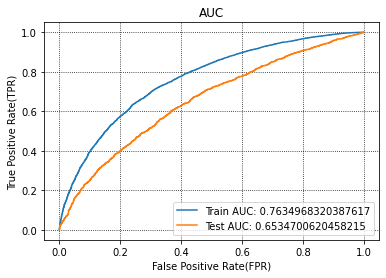

In [64]:
xgb_clf = XGBClassifier(n_estimators= best_param_n_estimators_s1,
                        learning_rate= best_param_eta_s1,
                        reg_alpha=0, reg_lambda=0, booster='gblinear')
xgb_clf.fit(X_tr_set1, y_train)

# Now we've to predict probabilities (clf.predict_proba) instead of classes for calculating of ROC AUC score
y_train_predicted = xgb_clf.predict_proba(X_tr_set1)[:, 1]
y_test_predicted = xgb_clf.predict_proba(X_te_set1)[:, 1]

train_fpr_s1, train_tpr_s1, train_thresholds_s1 = roc_curve(y_train, y_train_predicted)

test_fpr_s1, test_tpr_s1, test_thresholds_s1 = roc_curve(y_test, y_test_predicted)

plt.plot(train_fpr_s1, train_tpr_s1, label="Train AUC: "+str(auc(train_fpr_s1, train_tpr_s1)))
plt.plot(test_fpr_s1, test_tpr_s1, label="Test AUC: "+str(auc(test_fpr_s1, test_tpr_s1)))

plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("AUC")
plt.grid(b=True, which='major', color='k', linestyle=':')
plt.show()

#### Heat map or 3-D plot for SET - 1

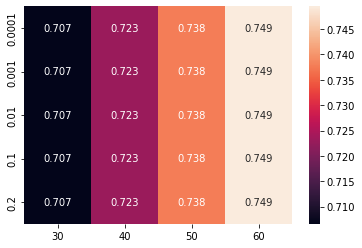

In [65]:
# Heatmap for train
train_auc_final_df_s1 = pd.DataFrame(train_auc_final_arr_s1, columns=n_estimators, index=learning_rates)
sns.heatmap(train_auc_final_df_s1, annot=True, fmt='.3g')
#title

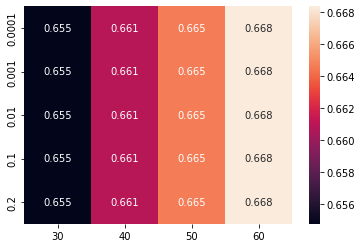

In [66]:
# Heatmap for test
test_auc_final_df_s1 = pd.DataFrame(test_auc_final_arr_s1, columns=n_estimators, index=learning_rates)
sns.heatmap(test_auc_final_df_s1, annot=True, fmt='.3g')
#title

In [67]:
# we are writing our own function for predict, with defined threshold
# we will pick a threshold that will give the least fpr
def find_best_threshold(threshold, fpr, tpr):
    t = threshold[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshold):
    predictions = []
    for i in proba:
        if i>= threshold:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

the maximum value of tpr*(1-fpr) 0.4885268235699276 for threshold 0.833
Train confusion matrix
[[ 3372  1536]
 [ 7828 19264]]


[Text(33.0, 0.5, 'Actual'), Text(0.5, 15.0, 'Predected')]

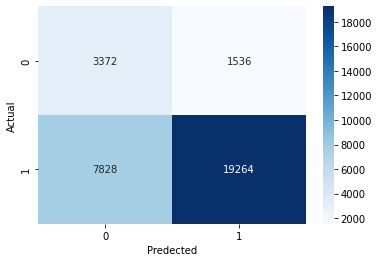

In [68]:
# Pick the best threshold among the probability estimates, such that it has to yield maximum value for TPR*(1-FPR)
# Plot the confusion matrices(each for train and test data) afer encoding the predicted class labels, on the basis of the best threshod probability estimate.

best_t = find_best_threshold(train_thresholds_s1, train_fpr_s1, train_tpr_s1)
print("Train confusion matrix")
cm_train_s1 = confusion_matrix(y_train, predict_with_best_t(y_train_predicted, best_t))
print(cm_train_s1)
p = sns.heatmap(cm_train_s1, annot=True, fmt="d", cmap='Blues')
p.set(xlabel='Predected', ylabel='Actual')

Test confusion matrix
[[ 667  560]
 [2157 4616]]


[Text(33.0, 0.5, 'Actual'), Text(0.5, 15.0, 'Predected')]

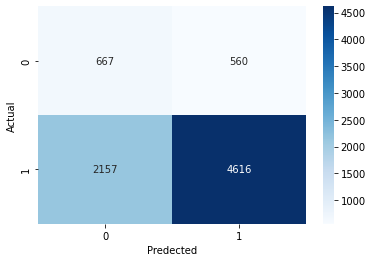

In [69]:
print("Test confusion matrix")
cm_test_s1 = confusion_matrix(y_test, predict_with_best_t(y_test_predicted, best_t))
print(cm_test_s1)
p = sns.heatmap(cm_test_s1, annot=True, fmt="d", cmap='Blues')
p.set(xlabel='Predected', ylabel='Actual') 

# SET 2

## 2.1. Using Pretrained Model: TFIDF weighted W2V

In [70]:
dictionary = dict(zip(vectorizer_essay_tfidf.get_feature_names(), list(vectorizer_essay_tfidf.idf_)))
tfidf_words = set(vectorizer_essay_tfidf.get_feature_names())

In [71]:
# Function to generate Word2Vec
def generate_w2v_from_text(essays_text_arr):
  # compute average word2vec for each review.
    tfidf_w2v_vectors = []
    # the avg-w2v for each sentence/review is stored in this list

    for sentence in tqdm(essays_text_arr):  # for each sentence
        vector = np.zeros(300)  # as word vectors are of zero length
        tf_idf_weight = 0
        # num of words with a valid vector in the sentence
        for word in sentence.split():  # for each word in a sentence
            if (word in glove_words) and (word in tfidf_words):
                vec = model[word]  # getting the vector for each word
                # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
                tf_idf = dictionary[word] * (
                    sentence.count(word) / len(sentence.split())
                )  # getting the tfidf value for each word
                vector += vec * tf_idf  # calculating tfidf weighted w2v
                tf_idf_weight += tf_idf
        if tf_idf_weight != 0:
            vector /= tf_idf_weight
        tfidf_w2v_vectors.append(vector)
    return tfidf_w2v_vectors


In [72]:
X_train_vectorized_tfidf_w2v_essay = generate_w2v_from_text(X_train['essay'].values)

100%|██████████| 32000/32000 [01:07<00:00, 476.05it/s]


In [73]:
X_test_vectorized_tfidf_w2v_essay = generate_w2v_from_text(X_test['essay'].values)

100%|██████████| 8000/8000 [00:17<00:00, 466.61it/s]


In [74]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
# from scipy.sparse import hstack
X_tr_set2 = np.hstack((X_train_vectorized_tfidf_w2v_essay,
                    X_train_clean_categories_response_proba_0,
                    X_train_clean_subcategories_response_proba_0,
                    X_train_project_grade_category_response_proba_0,
                    X_train_school_state_response_proba_0,
                    X_train_teacher_prefix_response_proba_0,
                    X_train_price_norm,
                    X_train_previously_posted_projects_norm,
                    X_train_essay_sentiment_neg,
                    X_train_essay_sentiment_neu,
                    X_train_essay_sentiment_pos,
                    X_train_essay_sentiment_comp))


X_te_set2 = np.hstack((X_test_vectorized_tfidf_w2v_essay,
                    X_test_clean_categories_response_proba_0,
                    X_test_clean_subcategories_response_proba_0,
                    X_test_project_grade_category_response_proba_0,
                    X_test_school_state_response_proba_0,
                    X_test_teacher_prefix_response_proba_0,
                    X_test_price_norm,
                    X_test_previously_posted_projects_norm,
                    X_test_essay_sentiment_neg,
                    X_test_essay_sentiment_neu,
                    X_test_essay_sentiment_pos,
                    X_test_essay_sentiment_comp))

print('Final Data Matrix')
print(X_tr_set2.shape, y_train.shape)
print(X_te_set2.shape, y_test.shape)
print('='*120)

Final Data Matrix
(32000, 311) (32000,)
(8000, 311) (8000,)


#### GridSearch on Set S2

In [75]:
xgb_clf_s2 = XGBClassifier(eval_metric='mlogloss')

In [76]:
%%time
grid_search_s2 = GridSearchCV(xgb_clf_s2, params, cv=3, scoring='roc_auc', return_train_score=True)
grid_search_s2.fit(X_tr_set2, y_train)

CPU times: user 18min 36s, sys: 1.36 s, total: 18min 37s
Wall time: 18min 31s


In [77]:
grid_search_s2.best_params_

{'eta': 0.0001, 'n_estimators': 60}

In [78]:
best_param_eta_s2, best_param_n_estimators_s2 = grid_search_s2.best_params_.values()

In [89]:
best_param_eta_s2 = 0.1

#### AUC for SET - 2

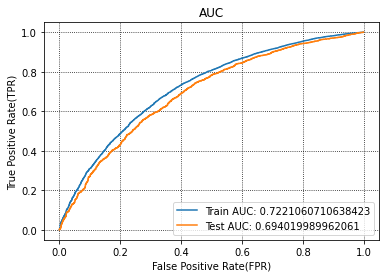

In [90]:
xgb_tfidf_w2v_clf = XGBClassifier(n_estimators=best_param_n_estimators_s2,
                        learning_rate=best_param_eta_s2,
                        reg_alpha=0, reg_lambda=0, booster='gblinear')
xgb_tfidf_w2v_clf.fit(X_tr_set2, y_train)

# I have to predict probabilities (clf.predict_proba) instead of classes for calculating of ROC AUC score:
y_train_predicted = xgb_tfidf_w2v_clf.predict_proba(X_tr_set2)[:, 1]
y_test_predicted = xgb_tfidf_w2v_clf.predict_proba(X_te_set2)[:, 1]

train_fpr_s2, train_tpr_s2, train_thresholds_s2 = roc_curve(y_train, y_train_predicted)

test_fpr_s2, test_tpr_s2, test_thresholds_s2 = roc_curve(y_test, y_test_predicted)

plt.plot(train_fpr_s2, train_tpr_s2, label="Train AUC: "+str(auc(train_fpr_s2, train_tpr_s2)))
plt.plot(test_fpr_s2, test_tpr_s2, label="Test AUC: "+str(auc(test_fpr_s2, test_tpr_s2)))

plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("AUC")
plt.grid(b=True, which='major', color='k', linestyle=':')
plt.show()

In [91]:
train_auc_final_arr_s2, test_auc_final_arr_s2 = get_auc_matrix(X_tr_set2, X_te_set2, y_train, y_test)
#print('Train_auc_final_arr_s2: ', train_auc_final_arr_s2)
#print('Test_auc_final_arr_s2: ', test_auc_final_arr_s2)

100%|██████████| 5/5 [08:56<00:00, 107.29s/it]


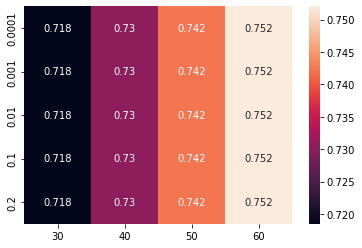

In [92]:
# Heatmap for train
train_auc_final_df_s2 = pd.DataFrame(train_auc_final_arr_s2, columns=n_estimators, index=learning_rates)
sns.heatmap(train_auc_final_df_s2, annot = True, fmt='.3g')
#title

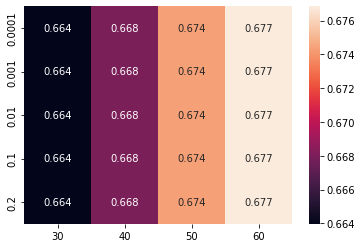

In [93]:
# Heatmap for test
test_auc_final_df_s2 = pd.DataFrame(test_auc_final_arr_s2, columns=n_estimators, index=learning_rates)
sns.heatmap(test_auc_final_df_s2, annot = True, fmt='.3g')
#title

the maximum value of tpr*(1-fpr) 0.44510942881576754 for threshold 0.829
Train confusion matrix
[[ 3152  1756]
 [ 8315 18777]]


[Text(33.0, 0.5, 'Actual'), Text(0.5, 15.0, 'Predected')]

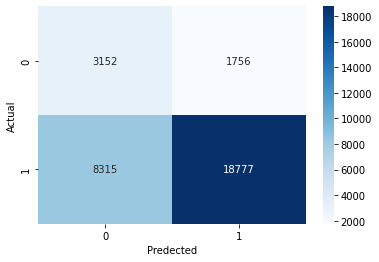

In [94]:
# Pick the best threshold among the probability estimates, such that it has to yield maximum value for TPR*(1-FPR)
# Plot the confusion matrices(each for train and test data) afer encoding the predicted class labels, on the basis of the best threshod probability estimate.

best_t = find_best_threshold(train_thresholds_s2, train_fpr_s2, train_tpr_s2)
print("Train confusion matrix")
cm_train_s2 = confusion_matrix(y_train, predict_with_best_t(y_train_predicted, best_t))
print(cm_train_s2)
p = sns.heatmap(cm_train_s2, annot=True, fmt="d", cmap='Blues')
p.set(xlabel='Predected', ylabel='Actual')

Test confusion matrix
[[ 742  485]
 [2144 4629]]


[Text(33.0, 0.5, 'Actual'), Text(0.5, 15.0, 'Predected')]

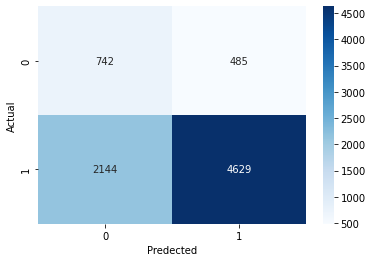

In [95]:
print("Test confusion matrix")
cm_test_s2 = confusion_matrix(y_test, predict_with_best_t(y_test_predicted, best_t))
print(cm_test_s2)
p = sns.heatmap(cm_test_s2, annot=True, fmt="d", cmap='Blues')
p.set(xlabel='Predected', ylabel='Actual')

<h1>3. Summary</h1>

<br> as mentioned in the step 4 of instructions

In [96]:
# Summarize your assignment work here in a few points, and also compare the final models (from set 1 and set 2), in terms of optimal hyperparameter values, training AUC and test AUC scores.
# You can either use a pretty table or any other tabular structure.
# Reference Link for Pretty table:  https://pypi.org/project/prettytable/
from prettytable import PrettyTable

x = PrettyTable()

x.field_names = ["Vectorizer", "Model", "Learning Rate", "Max Tree Depth", "Train AUC", "Test AUC"]


x.add_row(["TF-IDF",     "XGBoost", best_param_eta_s1, best_param_n_estimators_s1, round(auc(train_fpr_s1, train_tpr_s1), 2), round(auc(test_fpr_s1, test_tpr_s1), 2)])
x.add_row(["TF-IDF W2V", "XGBoost", best_param_eta_s2, best_param_n_estimators_s2, round(auc(train_fpr_s2, train_tpr_s2), 2), round(auc(test_fpr_s2, test_tpr_s2), 2)])

print(x)

+------------+---------+---------------+----------------+-----------+----------+
| Vectorizer |  Model  | Learning Rate | Max Tree Depth | Train AUC | Test AUC |
+------------+---------+---------------+----------------+-----------+----------+
|   TF-IDF   | XGBoost |     0.001     |       60       |    0.76   |   0.65   |
| TF-IDF W2V | XGBoost |      0.1      |       60       |    0.72   |   0.69   |
+------------+---------+---------------+----------------+-----------+----------+


In [97]:
drive.flush_and_unmount()
print('All changes made in this colab session should now be visible in Drive.')

Drive not mounted, so nothing to flush and unmount.
All changes made in this colab session should now be visible in Drive.
